In [290]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np
import csv
from zipfile import ZipFile

In [312]:
from time import time
import datetime
from pandas.core.common import flatten
from itertools import chain
from tqdm import tqdm
import warnings


In [5]:
# Parsing and pre-processing
import glob, re, os, sys, random
from random import shuffle

from langdetect import detect, DetectorFactory

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from string import punctuation
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [6]:
# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

In [314]:
# Modeling - Logistic, XGBOOST, SVM
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

from sklearn.pipeline import Pipeline, FeatureUnion

from xgboost import XGBClassifier
import pickle

In [8]:
# LSTM 
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import gc

In [9]:
# BERT models
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler
import transformers
from transformers import AutoModel, BertTokenizerFast

In [10]:
# specify GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

Load data

In [77]:
df = pd.read_json(r"../../../data/processed/pre-processed_2023_03_11.json")

Further pre-processing
- strip obvious words that can predict labels

### Phase 1 vs. Phase 2

Clean phase2 label

In [256]:
df1 = df[df['phase2'].isin([0,1])].reset_index(drop=True)

In [257]:
le = LabelEncoder()
df1['phase2'] = le.fit_transform(df1['phase2'])

In [258]:
print(df1.groupby('phase2')['case_num'].nunique(), "\n",
df1['phase2'].value_counts())

phase2
0    1485
1      98
Name: case_num, dtype: int64 
 0    5079
1     292
Name: phase2, dtype: int64


In [259]:
# Compute the number of cases per unique combination of phase2 and section_fin
case_counts = df1.groupby(['phase2', 'section_fin'])['case_num'].nunique()
print(case_counts)

phase2  section_fin              
0       Competitive Assessment       1256
        Concentration & Dimension    1467
        Market Definition             970
        Parties & Operation          1376
1       Competitive Assessment         75
        Concentration & Dimension      71
        Market Definition              81
        Parties & Operation            65
Name: case_num, dtype: int64


In [260]:
df1.groupby(['phase2', 'article_new', 'section_fin'])['case_num'].nunique()

phase2  article_new     section_fin              
0       article6(1)(b)  Competitive Assessment       1100
                        Concentration & Dimension    1273
                        Market Definition             839
                        Parties & Operation          1197
        article6(2)     Competitive Assessment        156
                        Concentration & Dimension     194
                        Market Definition             131
                        Parties & Operation           179
1       article8(1)     Competitive Assessment         17
                        Concentration & Dimension      24
                        Market Definition              29
                        Parties & Operation            24
        article8(2)     Competitive Assessment         49
                        Concentration & Dimension      41
                        Market Definition              45
                        Parties & Operation            35
        article8(3)   

Split to train, validation, test

In [261]:
# Separate the data into features (text) and labels (phase and section_fin)
X = df1['text_clean']
y = df1[['phase2', 'article_new', 'section_fin']]
case_num = df1['case_num']

# Define the number of splits and the test size
n_splits = 1
test_size = 0.2

# Initialize the StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

# Split the data into training and test sets
for train_index, test_index in sss.split(X, y):
    X_train_val, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_val, y_test = y.iloc[train_index], y.iloc[test_index]
    case_num_train_val, case_num_test = case_num.iloc[train_index], case_num.iloc[test_index]

# Further split the training_validation set into 75% training and 25% validation sets
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.25, random_state=42)
for train_index, val_index in sss.split(X_train_val, y_train_val):  # <-- Use X_train_val and y_train_val
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
    case_num_train, case_num_val = case_num_train_val.iloc[train_index], case_num_train_val.iloc[val_index]

# Print the shape of each set to verify that the data has been split correctly
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (3222,) (3222, 3)
Validation set shape: (1074,) (1074, 3)
Test set shape: (1075,) (1075, 3)


In [262]:
# Concatenate X_train_val, y_train_val, and case_num_train_val along axis=1
train_val_df = pd.concat([X_train_val, y_train_val, case_num_train_val], axis=1)

# Concatenate X_train, y_train, and case_num_train along axis=1
train_df = pd.concat([X_train, y_train, case_num_train], axis=1)

# Concatenate X_val, y_val, and case_num_val along axis=1
test_df = pd.concat([X_val, y_val, case_num_val], axis=1)

# Concatenate X_test, y_test, and case_num_test along axis=1
val_df = pd.concat([X_test, y_test, case_num_test], axis=1)

In [263]:
train_df.groupby(['phase2', 'section_fin'])['case_num'].nunique()

phase2  section_fin              
0       Competitive Assessment       753
        Concentration & Dimension    881
        Market Definition            582
        Parties & Operation          826
1       Competitive Assessment        45
        Concentration & Dimension     43
        Market Definition             48
        Parties & Operation           39
Name: case_num, dtype: int64

Vectorize X features in train, val, test

In [268]:
# vectorizer = TfidfVectorizer(vocabulary=vectorizer.get_feature_names())
vectorizer = TfidfVectorizer(analyzer = 'word', ngram_range = (3,4), binary = False, lowercase = True, min_df = 2, norm = 'l2', stop_words = None, use_idf = True)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_tfidf.shape

(3222, 432069)

1. Oversample minority class (phase2=1) using vectorized X_train_tfidf
---Oversampling minority class by balancing based on the number of cases and number of sections

In [269]:
# Oversampling
# Initialize oversampler with 'auto' sampling strategy
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Resample the training data
X_resampled, y_resampled = oversampler.fit_resample(X_train_tfidf, y_train['phase2'])
print(X_resampled.shape)
print(y_resampled.value_counts())

(6094, 432069)
0    3047
1    3047
Name: phase2, dtype: int64


2. Undersampling minority class (phase2=0) and excluded cases as test set
- don't split first and use df1

In [ ]:
# # Undersampling

# from imblearn.under_sampling import RandomUnderSampler

# # Find the number of samples in the minority class
# n_samples_minority = y_train['phase2'].value_counts()[1]

# # Use RandomUnderSampler to undersample the majority class
# undersampler = RandomUnderSampler(sampling_strategy={0: n_samples_minority}, random_state=42)
# X_resampled, y_resampled = undersampler.fit_resample(X_train_tfidf, y_train['phase2'])

Grid Search - Finetuning parameters

In [307]:
pipeline = Pipeline([
	('tfidf', TfidfVectorizer(analyzer='word')),
	('clf', LinearSVC())
])

In [308]:
parameters = {
	'tfidf__ngram_range': [(1,2),(1,1),(1,3),(1,4),(2,2),(2,3),(2,4),(3,3),(3,4),(4,4)],
	#'tfidf__analyzer': ('word', 'char'),
	'tfidf__lowercase': (True, False),
	#'tfidf__max_df': (0.01, 1.0), # ignore words that occur as more than 1% of corpus
	'tfidf__min_df': (1, 2, 3), # we need to see a word at least (once, twice, thrice)
	'tfidf__use_idf': (False, True),
	#'tfidf__sublinear_tf': (False, True),
	'tfidf__binary': (False, True),
	'tfidf__norm': (None, 'l1', 'l2'),
	#'tfidf__max_features': (None, 2000, 5000),
	'tfidf__stop_words': (None, 'english'),

	#'tfidfchar_ngram_range': ((1,1),(1,2),(1,3),(1,4),(1,5),(1,6),(2,2),(2,3),(2,4),(2,5),(2,6),(3,3),(3,4),(3,5),(3,6),(4,4),(4,5),(4,6),(5,5),(5,6),(1,7),(2,7),(3,7),(4,7),(5,7),(6,7),(7,7)),
	
	
	'clf__C':(0.1, 1, 5)
}

Train and evaluate - Logistic Regression

In [270]:
# Transform the test data using the same vectorizer as the training data
X_test_tfidf = vectorizer.transform(X_test)

# Fit the logistic regression model on the resampled data
clf = LogisticRegression(random_state=0).fit(X_resampled, y_resampled)

# Predict the class labels for the test data
y_pred = clf.predict(X_test_tfidf)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test['phase2'], y_pred) *100.0
precision = precision_score(y_test['phase2'], y_pred, average='binary')
recall = recall_score(y_test['phase2'], y_pred, average='binary')
f_score = 2 * (precision * recall) / (precision + recall)

print(f' Accuracy: {accuracy:.2f} \n Precision: {precision:.3f} \n Recall: {recall:.3f} \n F1: {f_score:.3f}')


 Accuracy: 96.37 
 Precision: 0.852 
 Recall: 0.397 
 F1: 0.541


Get feature importance

In [278]:
feature_names = vectorizer.get_feature_names()
coefs = clf.coef_[0]

# Create a dictionary of feature names and their corresponding coefficients
coef_dict = dict(zip(feature_names, coefs))

# Sort the dictionary by the absolute value of the coefficients
sorted_coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: abs(item[1]), reverse=True)}

# Print the top 10 most important features
for i, (feature, coef) in enumerate(sorted_coef_dict.items()):
    if i == 10:
        break
    print(f"{i+1}. {feature}: {coef:.2f}")


c:\Users\admin\anaconda3\envs\thesis\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


1. reply statement objection: 2.90
2. phase ii questionnaire: 2.32
3. cid cid cid: 2.26
4. flat carbon steel: 2.25
5. copyright administration service: 2.21
6. eur million vodafone: 2.16
7. pre rolled strip: 2.16
8. degussa food ingredient: 2.15
9. commission request information: 2.15
10. titanium dioxide pigment: 2.04


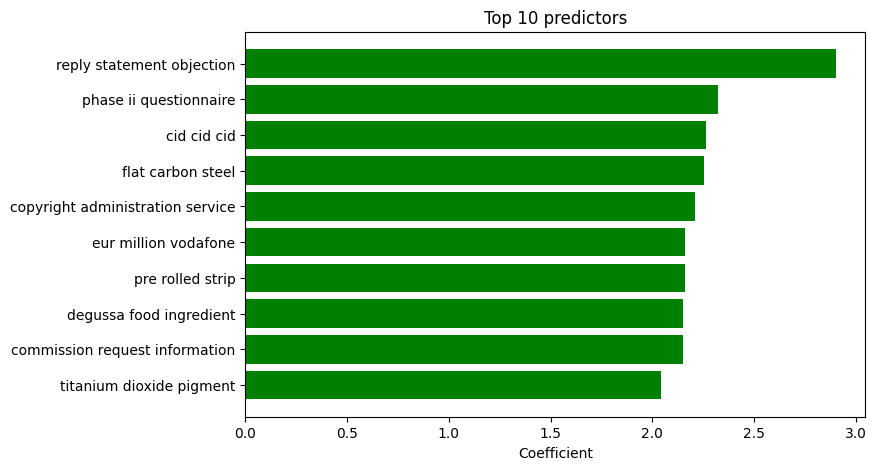

In [297]:
# Get the top 10 features and their coefficients
top_features_0 = list(sorted_coef_dict.keys())[:10]
top_coefs_0 = list(sorted_coef_dict.values())[:10]

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 5))
y_pos = range(len(top_features_0))
ax.barh(y_pos, top_coefs_0, align='center', color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_features_0)
ax.invert_yaxis()
ax.set_xlabel('Coefficient')
ax.set_title('Top 10 predictors')
plt.show()

In [298]:
# Get the index of phase2=1 and phase2=0 in the y_resampled array
idx_phase2_1 = np.where(y_resampled == 1)[0]
idx_phase2_0 = np.where(y_resampled == 0)[0]

# Get the coefficients for phase2=1 and phase2=0
coefs_phase2_1 = coefs[idx_phase2_1]
coefs_phase2_0 = coefs[idx_phase2_0]

# Get the feature names for phase2=1 and phase2=0
feature_names_phase2_1 = [feature_names[i] for i in idx_phase2_1]
feature_names_phase2_0 = [feature_names[i] for i in idx_phase2_0]

# Create a dictionary of feature names and their corresponding coefficients for phase2=1 and phase2=0
coef_dict_phase2_1 = dict(zip(feature_names_phase2_1, coefs_phase2_1))
coef_dict_phase2_0 = dict(zip(feature_names_phase2_0, coefs_phase2_0))

# Sort the dictionary by the absolute value of the coefficients for phase2=1 and phase2=0
sorted_coef_dict_phase2_1 = {k: v for k, v in sorted(coef_dict_phase2_1.items(), key=lambda item: abs(item[1]), reverse=True)}
sorted_coef_dict_phase2_0 = {k: v for k, v in sorted(coef_dict_phase2_0.items(), key=lambda item: abs(item[1]), reverse=True)}

# Print the top 10 most important features for phase2=1
print("Top 10 phase2=1 predictors:")
for i, (feature, coef) in enumerate(sorted_coef_dict_phase2_1.items()):
    if i == 10:
        break
    print(f"{i+1}. {feature}: {coef:.2f}")

# Print the top 10 most important features for phase2=0
print("\nTop 10 phase2=0 predictors:")
for i, (feature, coef) in enumerate(sorted_coef_dict_phase2_0.items()):
    if i == 10:
        break
    print(f"{i+1}. {feature}: {coef:.2f}")


Top 10 phase2=1 predictors:
1. acetic acid acetic: 0.72
2. acetic acid vam: 0.72
3. active design development: 0.70
4. achieved third aggregate union: 0.70
5. active globally main: 0.69
6. achieve third aggregate eu: -0.64
7. achieves third turnover: 0.60
8. acquired investment fund: 0.56
9. active exploration production: 0.54
10. acquisition joint control: -0.52

Top 10 phase2=0 predictors:
1. ab wholly owned: 0.46
2. ab wholly owned subsidiary: 0.46
3. ab ultimately controlled: 0.42
4. according information provided party: 0.36
5. according exchange rate: 0.33
6. according information provided: 0.33
7. according notifying party: 0.22
8. abn amro asset: -0.22
9. able commercially launch: 0.21
10. ability incentive foreclose: -0.21


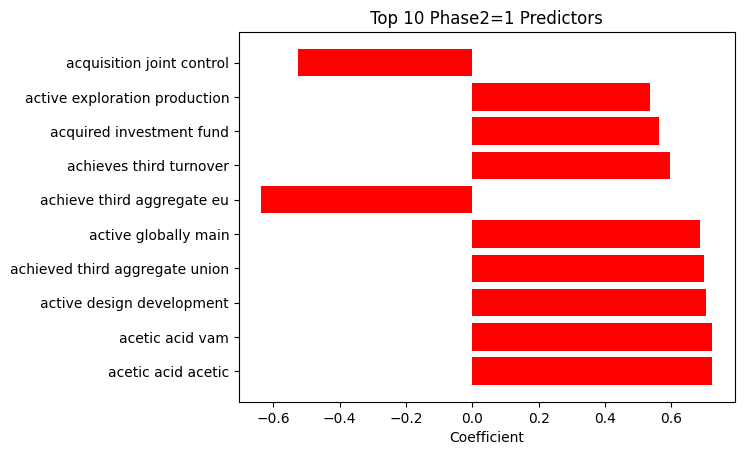

In [302]:
import matplotlib.pyplot as plt

# Get the top 10 feature names and coefficients for phase2=1
top_10_features_phase2_1 = list(sorted_coef_dict_phase2_1.keys())[:10]
top_10_coefs_phase2_1 = list(sorted_coef_dict_phase2_1.values())[:10]

# Create a horizontal bar chart with blue bars for phase2=1
fig, ax = plt.subplots()
ax.barh(top_10_features_phase2_1, top_10_coefs_phase2_1, color='red')
ax.set_xlabel('Coefficient')
ax.set_title('Top 10 Phase2=1 Predictors')
plt.show()

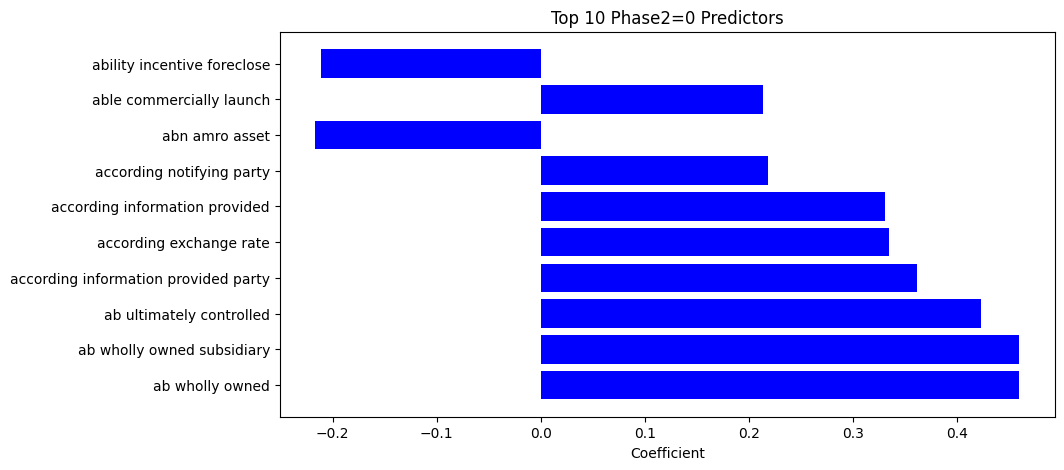

In [303]:
# Get the top 10 coefficients for phase2=0
top_coef_0 = sorted([(k, v) for k, v in coef_dict_phase2_0.items()], key=lambda x: abs(x[1]), reverse=True)[:10]

# Extract the feature names and coefficients for phase2=0
features_0, coefs_0 = zip(*top_coef_0)

# Create a horizontal bar chart for the top 10 coefficients for phase2=0
plt.figure(figsize=(10, 5))
plt.barh(range(len(coefs_0)), coefs_0, align='center', color='blue')
plt.yticks(range(len(features_0)), features_0)
plt.xlabel('Coefficient')
plt.title('Top 10 Phase2=0 Predictors')
plt.show()


Create pipeline

In [205]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC

# Create pipeline with TfidfVectorizer, RandomOverSampler, and LinearSVC
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word')),
    ('ros', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('clf', LinearSVC())
])


In [206]:
pipeline.fit(X_train, y_train['phase2'])

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('ros', RandomOverSampler(random_state=42)),
                ('clf', LinearSVC())])

In [145]:
pipeline = Pipeline([
	('tfidf', TfidfVectorizer(analyzer='word')),
	('clf', LinearSVC())
])